# **Deep learning for image analysis with Python**

#### Fernando Cervantes, Systems Analyst I, Imaging Solutions, Research IT
#### fernando.cervantes@jax.org    (slack) @fernando.cervantes

## 5 Implement the training loop

### 5.1 _Data preparation_

Using the *torchvision* library, pull the CIFAR 100 dataset.<br>
We'll need to transform images from this dataset from PIL Images to PyTorch tensors.

In [1]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [8]:
cifar_data = CIFAR100(root='/home/cervaf/data',
                             download=False,
                             train=True,
                             transform=ToTensor()
                            )

In [9]:
cifar_loader = DataLoader(cifar_data,
                              batch_size=128,
                              shuffle=True,
                              pin_memory=True
                             )

In [10]:
print('Dataset size:', len(cifar_data))
print('DataLoader size:', len(cifar_loader))

Dataset size: 50000
DataLoader size: 391


Plot some of the CIFAR labeled examples. Check [here](https://huggingface.co/datasets/cifar100) the labels

torch.Size([3, 32, 32])


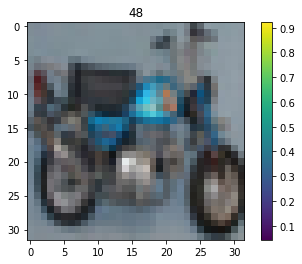

In [11]:
import matplotlib.pyplot as plt

x, t = cifar_data[10000]
print(x.size())
plt.imshow(x.permute(1, 2, 0))
plt.title(t)
plt.colorbar()
plt.show()

***
### 5.2 _Network preparation_

Implement a Residual Network ([ResNet](https://arxiv.org/pdf/1512.03385.pdf))<br>
The torchvision module from pytorch provides models that have been pre-trained with the ImageNet dataset (1.2 million images natural images for training, with 1000 different classes)<br>
This is usefull for *transfer the learning* to other applications, or use those as *warmed-up* models, instead of random initialization of the weights.<br>
However, the architecture is fixed to work with input images of $224\times224$ pixels with $3$ channels (RBG), and output $1000$ classes.<br>
For our example with the CIFAR 100 dataset, that is composed by images of $32\times32$ pixesl in RGB, and only has $100$ classes, thre pre-trained models won't be usefull.


In [50]:
import torchvision.models as models

In [51]:
print(models.resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Lets use our LeNet network that we implemented as a custom pytorch Module

In [12]:
import torch
import torch.nn as nn


class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        """
        Always call the initialization function from the nn.Module parent class.
        This way all parameters from the operations defined as members of *this* class are tracked for their optimization.
        """
        super(LeNet, self).__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.sub_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.sub_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc_1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.fc_2 = nn.Linear(in_features=120, out_features=84)
        self.fc_3 = nn.Linear(in_features=84, out_features=num_classes)
        
        self.act_fn = nn.ReLU()

    def forward(self, x):
        # Apply convolution layers to extract feature maps with image context
        fx = self.act_fn(self.conv_1(x))
        fx = self.sub_1(fx)
        
        fx = self.act_fn(self.conv_2(fx))
        fx = self.sub_2(fx)
        
        # Flatten the feature maps to perform linear operations
        fx = fx.view(-1, 16*5*5)
        
        fx = self.act_fn(self.fc_1(fx))
        fx = self.act_fn(self.fc_2(fx))
        y = self.fc_3(fx)
        
        return y

Alternatively, we can define the layers of our network using the Sequential function to reduce the code in the forward pass

In [73]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        """
        Always call the initialization function from the nn.Module parent class.
        This way all parameters from the operations defined as members of *this* class are tracked for their optimization.
        """
        super(LeNet, self).__init__()
        
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        self.layer_fc = nn.Sequential(
            nn.Linear(in_features=5*5*16, out_features=120, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84, bias=True),
            nn.ReLU(),        
            nn.Linear(in_features=84, out_features=num_classes, bias=True)
        )

    def forward(self, x):    
        fx = self.layer_1(x) 
        fx = self.layer_2(x)

        fx = fx.flatten()

        logits = self.layer_fc(x)
        
        return logits


Or even have all layers as a single operation

In [74]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        """
        Always call the initialization function from the nn.Module parent class.
        This way all parameters from the operations defined as members of *this* class are tracked for their optimization.
        """
        super(LeNet, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(in_features=5*5*16, out_features=120, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84, bias=True),
            nn.ReLU(),        
            nn.Linear(in_features=84, out_features=num_classes, bias=True)
        )

    def forward(self, x):
        logits = self.layers(x)
        
        return logits

***
### 5.3 _Definition of the optimization problem_

Define the loss function and the optimizer, and test it.

In [74]:
import torch.optim as optim

net = LeNet(in_channels=3, num_classes=100)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    params=net.parameters(),
    lr=1e-3
)

In [57]:
optimizer.zero_grad() # Clean the gradient accumulator

x, t = cifar_data[1]

y = net(x.view(1, 3, 32, 32))
loss = criterion(y, torch.tensor([t]))

loss.backward()

optimizer.step() # In this command, the parameters of the network are updated

In [58]:
print('Loss before one step of optimization %.8f' % loss)

Loss before one step of optimization 4.65875435


In [59]:
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

In [60]:
starter.record()
x, t = cifar_data[1]

optimizer.zero_grad() # Clean the gradient accumulator

y = net(x.view(1, 3, 32, 32))
loss = criterion(y, torch.tensor([t]))

loss.backward()

optimizer.step()
ender.record()
torch.cuda.synchronize()

In [61]:
print('Loss after one step of optimization %.8f (%.4f ms)' % (loss, starter.elapsed_time(ender)))

Loss after one step of optimization 4.56975365 (5.3052 ms)


***
### Setup for training in GPU

In [79]:
net = LeNet(in_channels=3, num_classes=100)
criterion = nn.CrossEntropyLoss()

# Move our network to the GPU memory, as well as our criterion

net.cuda()
criterion.cuda()

# Define the optimizer after we have moved the network to the GPU, so the update is perfomred in GPU momory
optimizer = optim.Adam(
    params=net.parameters(),
    lr=1e-4
)

In [80]:
starter.record()
x, t = cifar_data[1]

optimizer.zero_grad() # Clean the gradient accumulator

# Move the input to GPU memory before feeding the network with it
y = net(x.view(1, 3, 32, 32).cuda())

# Move the target as well to compute the loss on the GPU
loss = criterion(y, torch.tensor([t]).cuda())

loss.backward()

optimizer.step()

# this is necesary only when measuring the execution time
ender.record()
torch.cuda.synchronize()

In [81]:
print('Loss after one step of optimization %.16f (%.16f ms)' % (loss, starter.elapsed_time(ender)))

Loss after one step of optimization 4.5440969467163086 (6.7426238059997559 ms)


***
### 5.4 _Implement the training loop_

The DataLoader class in PyTorch is usefull to split the dataset into batches.<br>
It also convert the individual targets to tensors that can be used directly by the loss function

#### Run one *epoch* of training

In [82]:
starter.record()
trn_loss = []
for i, (x, t) in enumerate(cifar_loader):
    optimizer.zero_grad()
    
    x = x.cuda()
    t = t.cuda()
    
    y = net(x)
    
    loss = criterion(y, t)
    
    loss.backward()
    
    trn_loss.append(loss.item())
    
    optimizer.step()
    
    if i % 100 == 0:
        print('[%i] Loss %.8f' % (i, loss))
        
ender.record()
torch.cuda.synchronize()

[0] Loss 4.61580658
[100] Loss 4.60999680
[200] Loss 4.60738468
[300] Loss 4.58368683


In [83]:
starter.elapsed_time(ender) / 1000

8.3254638671875

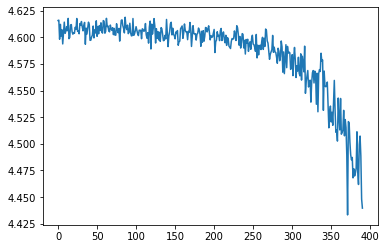

In [84]:
plt.plot(trn_loss)

#### Run several *epochs*

In [85]:
trn_loss = []
net.train()

starter.record()

for e  in range(10):
    avg_loss = 0
    for i, (x, t) in enumerate(cifar_loader):
        optimizer.zero_grad()

        x = x.cuda()
        t = t.cuda()
        
        y = net(x)

        loss = criterion(y, t)

        loss.backward()
        
        avg_loss += loss.item()
        trn_loss.append(loss.item())

        optimizer.step()
    
    avg_loss = avg_loss / len(cifar_loader)
    print('[Epoch %02i] %.8f' % (e, avg_loss))

ender.record()
torch.cuda.synchronize()

[Epoch 00] 4.22050981
[Epoch 01] 4.05877465
[Epoch 02] 3.98134269
[Epoch 03] 3.92504284
[Epoch 04] 3.87726392
[Epoch 05] 3.83519708
[Epoch 06] 3.79661869
[Epoch 07] 3.75771317
[Epoch 08] 3.72181185
[Epoch 09] 3.68597978


In [86]:
starter.elapsed_time(ender) / 1000

86.3834609375

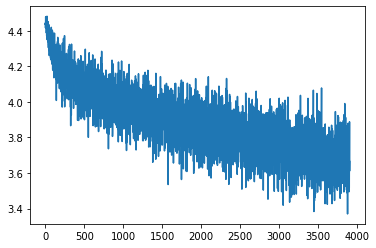

In [87]:
plt.plot(trn_loss)

#### Save the trained model (checkpoint)

In [104]:
torch.save(net.state_dict(), 'lenet_20220420.pth')

***
#### Test the trained model
Use the test partition of the CIFAR 100 dataset

In [105]:
cifar_tst_dataset = CIFAR100(root='/home/cervaf/data', download=False, train=False, transform=cifar_transform)
cifar_tst_loader = DataLoader(cifar_tst_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [106]:
import sklearn.metrics
import numpy as np

In [154]:
# Load the checkpoint
state_dict = torch.load('lenet_20220420.pth')

In [155]:
for k in state_dict.keys():
    print(k)

embedding.weight
bn.weight
bn.bias
bn.running_mean
bn.running_var
bn.num_batches_tracked
layers.0.conv_1.weight
layers.0.downsample.weight
layers.0.bn1.weight
layers.0.bn1.bias
layers.0.bn1.running_mean
layers.0.bn1.running_var
layers.0.bn1.num_batches_tracked
layers.0.conv_2.weight
layers.0.bn2.weight
layers.0.bn2.bias
layers.0.bn2.running_mean
layers.0.bn2.running_var
layers.0.bn2.num_batches_tracked
layers.1.conv_1.weight
layers.1.bn1.weight
layers.1.bn1.bias
layers.1.bn1.running_mean
layers.1.bn1.running_var
layers.1.bn1.num_batches_tracked
layers.1.conv_2.weight
layers.1.bn2.weight
layers.1.bn2.bias
layers.1.bn2.running_mean
layers.1.bn2.running_var
layers.1.bn2.num_batches_tracked
layers.2.conv_1.weight
layers.2.downsample.weight
layers.2.bn1.weight
layers.2.bn1.bias
layers.2.bn1.running_mean
layers.2.bn1.running_var
layers.2.bn1.num_batches_tracked
layers.2.conv_2.weight
layers.2.bn2.weight
layers.2.bn2.bias
layers.2.bn2.running_mean
layers.2.bn2.running_var
layers.2.bn2.num_bat

In [156]:
# Create a new network object
test_net = LeNet(in_channels=3, num_classes=100)

In [157]:
# Load the trained weights
test_net.load_state_dict(state_dict)

<All keys matched successfully>

#### Test the accuracy of the trained network

In [158]:
tst_avg_loss = 0
tst_avg_acc = 0
tst_avg_acc_5 = 0
tst_avg_acc_10 = 0

test_net.cuda()
test_net.eval()

for i, (x, t) in enumerate(cifar_tst_loader):
    with torch.no_grad():
        x = x.cuda()
        t = t.cuda()
        
        y = test_net(x)
        loss = criterion(y, t)
    
    tst_avg_loss += loss.item()

    tst_avg_acc += sklearn.metrics.accuracy_score(t.cpu().numpy(), y.cpu().argmax(dim=1).numpy(), normalize=False)
    tst_avg_acc_5 += sklearn.metrics.top_k_accuracy_score(t.cpu().numpy(), y.cpu().numpy(), k=5, labels=np.arange(100), normalize=False)
    tst_avg_acc_10 += sklearn.metrics.top_k_accuracy_score(t.cpu().numpy(), y.cpu().numpy(), k=10, labels=np.arange(100), normalize=False)

tst_avg_loss = tst_avg_loss / len(cifar_tst_loader)
tst_avg_acc = tst_avg_acc / len(cifar_tst_dataset) * 100
tst_avg_acc_5 = tst_avg_acc_5 / len(cifar_tst_dataset) * 100
tst_avg_acc_10 = tst_avg_acc_10 / len(cifar_tst_dataset) * 100
print('Average test loss %.8f, average accuracy %.2f %%, average accuracy@5 %.2f %%, average accuracy@10 %.2f %%' % (tst_avg_loss, tst_avg_acc, tst_avg_acc_5, tst_avg_acc_10))

Average test loss 4.78111167, average accuracy 46.62 %, average accuracy@5 73.20 %, average accuracy@10 82.53 %


Check with a sample image from the training set

In [159]:
x, t = cifar_trn_dataset[100]
x = x.cuda()
y = test_net(x.view(1, 3, 32, 32))

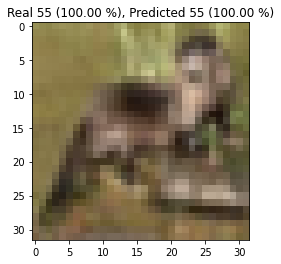

In [160]:
plt.imshow(x.cpu().permute(1, 2, 0))
plt.title('Real %i (%.2f %%), Predicted %i (%.2f %%)' % (t, torch.softmax(y, dim=1)[0, t].item() * 100, y.cpu().argmax(dim=1)[0].item(), torch.softmax(y, dim=1).max().item() * 100))
plt.show()

Check the labels [here](https://huggingface.co/datasets/cifar100)

Check one image from the test set

In [189]:
x, t = cifar_tst_dataset[5550]
x = x.cuda()
y = test_net(x.view(1, 3, 32, 32))

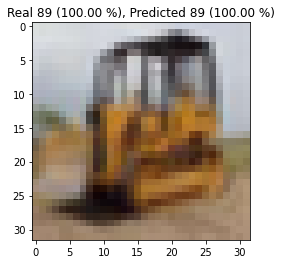

In [190]:
plt.imshow(x.cpu().permute(1, 2, 0))
plt.title('Real %i (%.2f %%), Predicted %i (%.2f %%)' % (t, torch.softmax(y, dim=1)[0, t].item() * 100, y.cpu().argmax(dim=1)[0].item(), torch.softmax(y, dim=1).max().item() * 100))
plt.show()